In [1]:
from netCDF4 import Dataset
import pandas as pd
from cartoplot import cartoplot
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
from contourpy import contour_generator
from scipy.ndimage import label
from ll_xy import lonlat_to_xy
import tqdm
import shapely

/tmp/ipykernel_22841/234341250.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
edge_dir = '../../ice_edge/data/'
edge_dir = '/media/robbie/One Touch/ARCTEX/ice_edge_cdr'

In [3]:
with Dataset(f'{edge_dir}/ice_edge_nh_ease2-125_cdr-v3p0_200607011200.nc') as d:
    it_lon = np.array(d['lon'])
    it_lat = np.array(d['lat'])

# Convert to EPSG 3408

xgrid,ygrid = lonlat_to_xy(it_lon,it_lat,hemisphere='n')


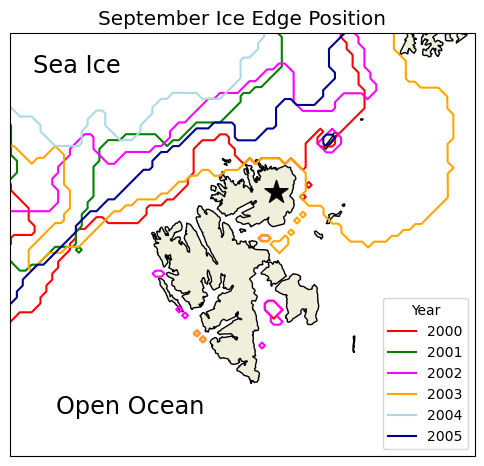

In [4]:
fig = plt.figure(figsize=(6,6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)

ax.set_extent([-180, 180,90, 65], ccrs.PlateCarree())

ax.set_extent([-0.09e+06, 0.9e6, -1.6e6, -0.7e6], crs=ccrs.NorthPolarStereo()) 

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

month = '09'

for year, color in zip(np.arange(2000,2016),['r','g','magenta','orange','lightblue','darkblue',]):

    with Dataset(f'{edge_dir}/ice_edge_nh_ease2-125_cdr-v3p0_{year}{month}011200.nc') as d:
        
        it = np.array(d['ice_edge'][0]).astype(np.float32)
        it[it<=1] = 0
        it[it>0] = 1
        
        cont = ax.contour(xgrid,
                          ygrid,
                          it,
                          levels=[0.5],
                          transform=cartopy.crs.epsg('3408'),
                          colors=[color])

        ax.plot([],[],color=color,label=year)

ax.set_title('September Ice Edge Position',fontsize='x-large')
ax.annotate('Sea Ice',xy=(0.05,0.95),va='top',xycoords='axes fraction',fontsize='xx-large')
ax.annotate('Open Ocean',xy=(0.1,0.1),xycoords='axes fraction',fontsize='xx-large')
ax.scatter(24.6,79.8,transform=ccrs.PlateCarree(),marker='*',s=302,c='k')
ax.legend(title='Year',loc='lower right')
fig.savefig('Ice_Edge_Jan25.png',dpi=400,bbox_inches='tight')

In [5]:
full_month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']

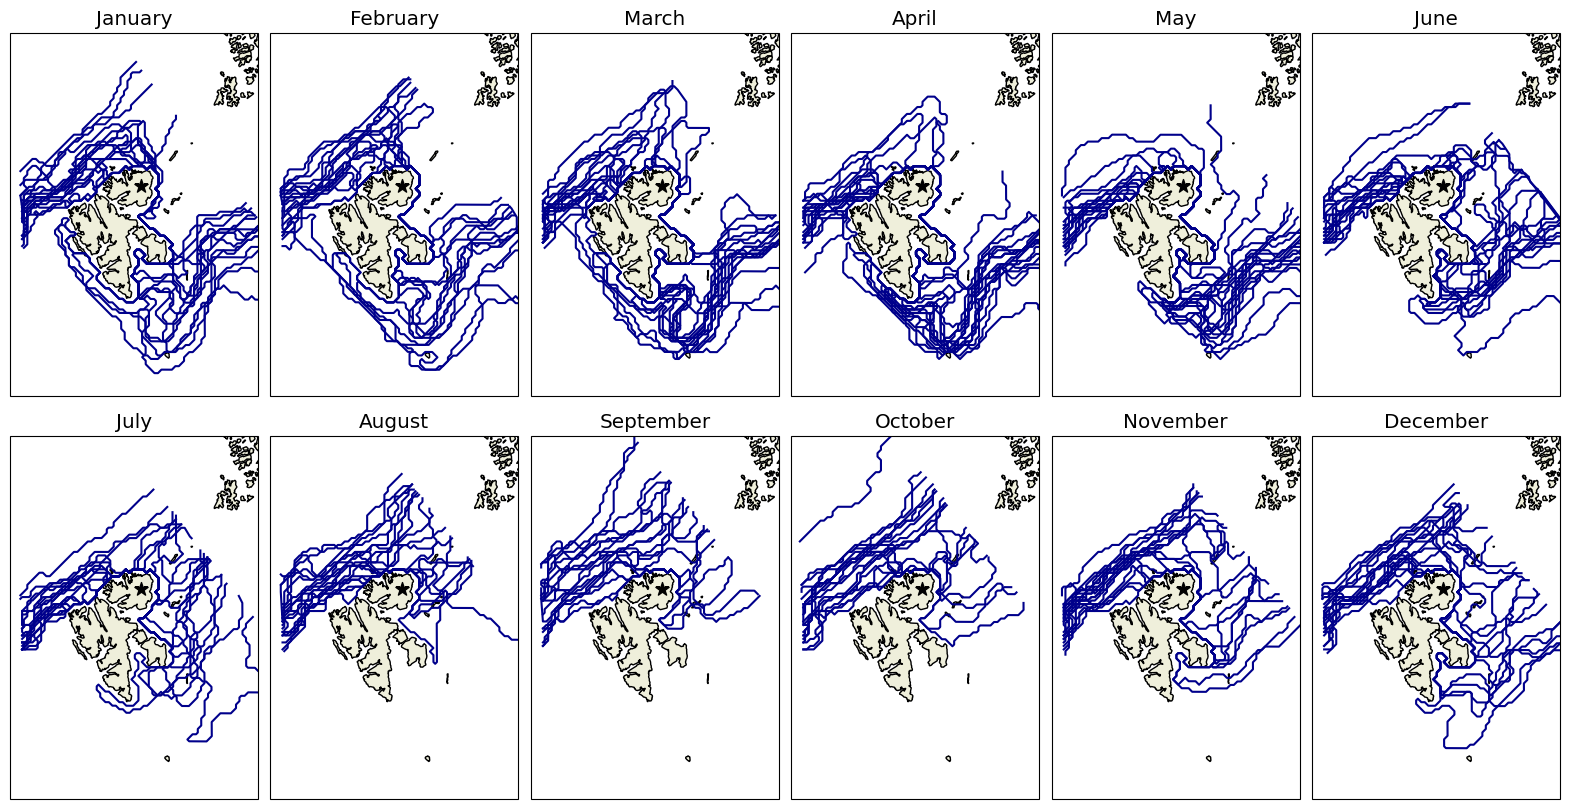

In [6]:
proj = ccrs.NorthPolarStereo()
fig,axs = plt.subplots(2,6,figsize=(20,10),subplot_kw={'projection':proj})

edges = {}

for m, ax in zip(np.arange(1,13),axs.reshape(-1)):

    edges[m] = []

    ax.set_extent([0, 30,85, 74], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    month = str(m).zfill(2)
    ax.set_title(full_month_names[m-1],fontsize='x-large')

    for year in np.arange(2002,2021):
    
        with Dataset(f'{edge_dir}/ice_edge_nh_ease2-125_cdr-v3p0_{year}{month}011200.nc') as d:
            
            it = np.array(d['ice_edge'][0]).astype(np.float32)
            it[it<=1] = 0
            it[it>0] = 1
            
            it[it_lon>40]=0
            it[it_lon<0]=0
    
            cont_gen = contour_generator(z=it,x=xgrid,y=ygrid)
    
            lines = cont_gen.lines(0.5)
    
            line_lengths = [len(l) for l in lines]
    
            longest_line = lines[np.argmax(line_lengths)]
    
            x = longest_line[:,0]
            y = longest_line[:,1]
            lonline,latline=lonlat_to_xy(x,y,hemisphere='n',inverse=True)
    
            xclean = x[((lonline>2) & (lonline<38))&(latline<88)]
            yclean = y[((lonline>2) & (lonline<38))&(latline<88)]
            ax.plot(xclean,yclean,transform=cartopy.crs.epsg('3408'),color=color,label=year)

            edges[m].append((xclean,yclean))

    
    ax.scatter(24.6,79.8,transform=ccrs.PlateCarree(),marker='*',s=100,c='k')

    fig.subplots_adjust(wspace=0.05,hspace=0.1)
    
fig.savefig('Edges_by_month_Jan25.png',dpi=400,bbox_inches='tight')

# Calculate centre of mass of line

Text(0, 0.5, 'Y Distance (m)')

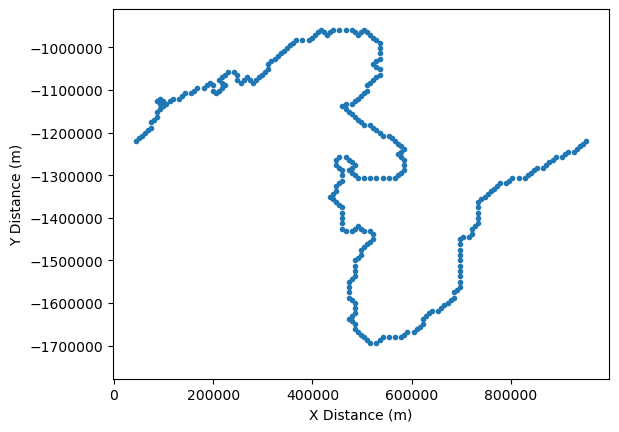

In [7]:
x,y=edges[1][0][0],edges[1][0][1]


plt.scatter(x,y,marker='.')
plt.ticklabel_format(style='plain')

plt.ylim(np.nanmin(y)*1.05,np.nanmax(y)*0.95)

plt.xlabel('X Distance (m)')
plt.ylabel('Y Distance (m)')

Text(0, 0.5, 'Y Distance (m)')

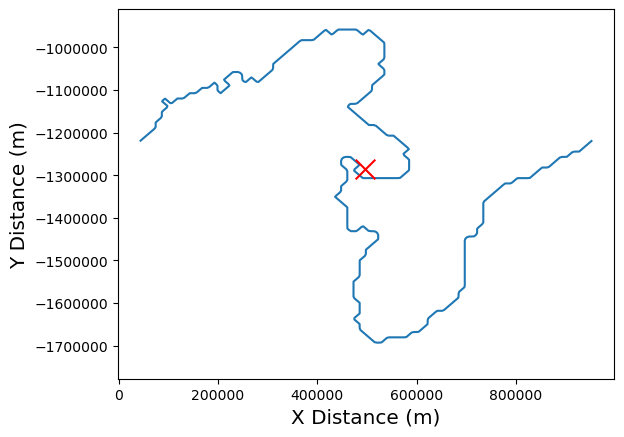

In [8]:
x,y=edges[1][0][0],edges[1][0][1]

line = shapely.LineString(np.array([x,y]).T)

distance_delta=5000
distances = np.arange(0,line.length,distance_delta)

points = [line.interpolate(distance) for distance in distances]
new_line = shapely.LineString(points)

x_ = np.array(new_line.coords)[:,0]
y_ = np.array(new_line.coords)[:,1]

xbar = np.nanmean(x_)
ybar = np.nanmean(y_)

plt.scatter(xbar,ybar,marker='x',c='r',s=200,zorder=5)

plt.plot(x_,y_)
plt.ticklabel_format(style='plain')

plt.ylim(np.nanmin(y_)*1.05,np.nanmax(y_)*0.95)

plt.xlabel('X Distance (m)',fontsize='x-large')
plt.ylabel('Y Distance (m)',fontsize='x-large')

In [9]:
def calc_line_COM(x,y):
    
    line = shapely.LineString(np.array([x,y]).T)

    distance_delta=5000
    distances = np.arange(0,line.length,distance_delta)

    points = [line.interpolate(distance) for distance in distances]
    new_line = shapely.LineString(points)

    x_ = np.array(new_line.coords)[:,0]
    y_ = np.array(new_line.coords)[:,1]

    xbar = np.nanmean(x_)
    ybar = np.nanmean(y_)
    
    return(xbar,ybar)

In [10]:
coms = {}

for month in tqdm.trange(1,13):
    
    coms[month] = []
    
    q = edges[month]

    for year_ind in range(len(q)):

        x,y = q[year_ind][0],q[year_ind][1]
        
        xbar,ybar = calc_line_COM(x,y)
        
        lonbar,latbar = lonlat_to_xy(np.array(xbar),np.array(ybar),inverse=True,hemisphere='n')
        
        coms[month].append((lonbar,latbar))

100%|███████████████████████████████████████████| 12/12 [00:05<00:00,  2.17it/s]


In [11]:
years = np.arange(2002,2021)

for key in coms.keys():
    
    month_name = full_month_names[key-1]
    
    xseries,yseries = np.array(coms[key])[:,0],np.array(coms[key])[:,1]
    
    df = pd.DataFrame({'lon':xseries,'lat':yseries,'year':years})

    df.to_hdf('edge_COM.h5',key=month_name,mode='a')

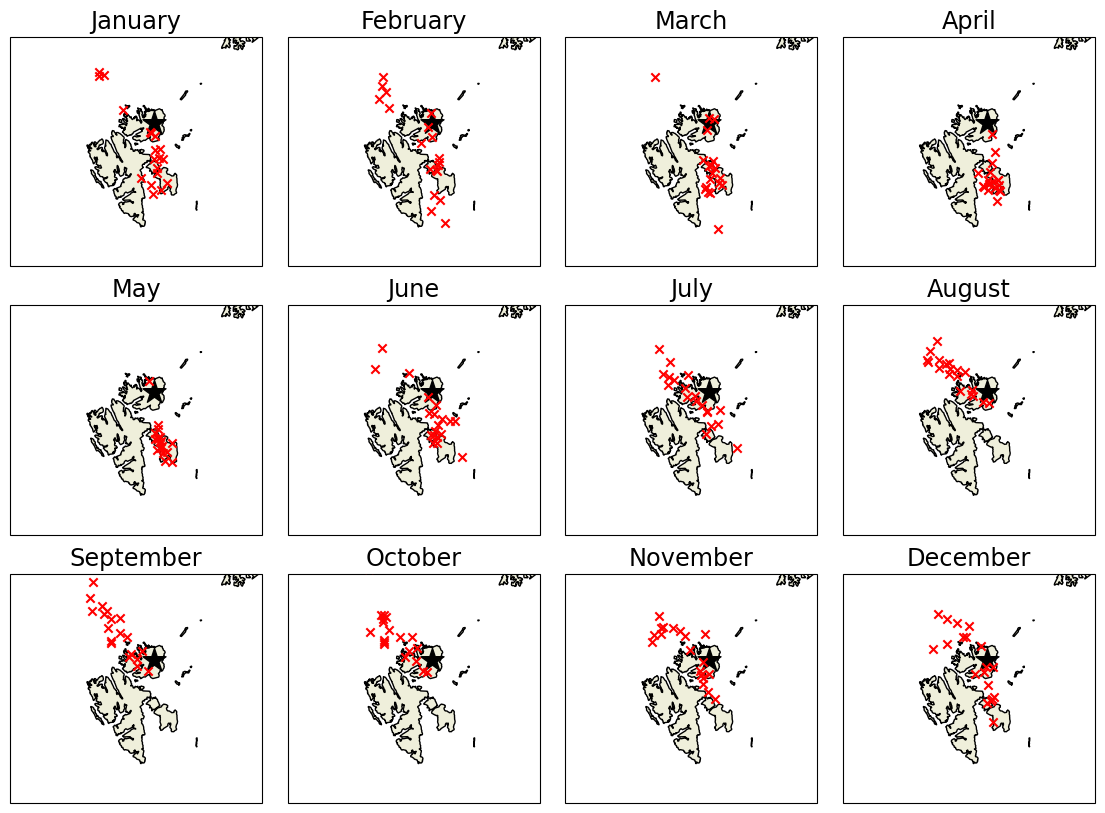

In [134]:
proj = ccrs.NorthPolarStereo()
fig,axs = plt.subplots(3,4,figsize=(14,10),subplot_kw={'projection':proj})

for monthnum,ax in zip(np.arange(1,13),axs.reshape(-1)):
    
    df = pd.read_hdf('edge_COM.h5',mode='r',key=full_month_names[monthnum-1])

    ax.scatter(df['lon'],df['lat'],transform=ccrs.PlateCarree(),zorder=5,marker='x',color='r')

    ax.set_extent([-180, 180,90, 65], ccrs.PlateCarree())

    ax.set_extent([-0.09e+06, 0.9e6, -1.6e6, -0.7e6], crs=ccrs.NorthPolarStereo()) 

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

    ax.set_title(f'{full_month_names[monthnum-1]}',fontsize='xx-large')
    ax.scatter(24.6,79.8,transform=ccrs.PlateCarree(),marker='*',s=302,c='k')

plt.subplots_adjust(wspace=0.1,hspace=0.15)
    
fig.savefig('EDGE_COMS_Jan25.png',dpi=400,bbox_inches='tight')

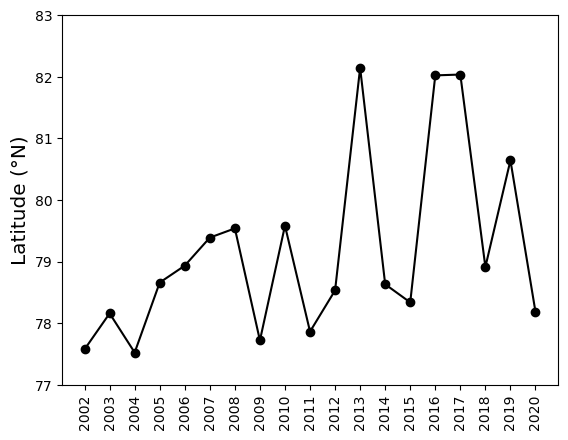

In [12]:
monthnum=1

xseries,yseries = np.array(coms[monthnum])[:,0],np.array(coms[monthnum])[:,1]

plt.plot(years,yseries,marker='o',color='k')
plt.ylim(77,83)
plt.xticks(years,rotation=90)
plt.ylabel('Latitude (°N)',fontsize='x-large')
plt.show()